# Future Weather Files Morphing Workflow



### Following the methodology from
https://weathershift.com/resources/public/Constructing%20Design%20Weather.pdf

### Set the DATADIR variable below and run the following cells

In [26]:
DATADIR = './GLOBAL/'

In [37]:
import os
from glob import glob
from numpy import array
import xarray as xr
from typing import Dict, List
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from ladybug.datacollection import (
    BaseCollection,
    HourlyContinuousCollection,
    MonthlyCollection,
)
from ladybug.datatype.energyflux import (
    DiffuseHorizontalRadiation,
    DirectNormalRadiation,
    GlobalHorizontalRadiation,
)
from ladybug.datatype.fraction import OpaqueSkyCover, RelativeHumidity, TotalSkyCover
from ladybug.datatype.illuminance import (
    DiffuseHorizontalIlluminance,
    DirectNormalIlluminance,
    GlobalHorizontalIlluminance,
)
from ladybug.datatype.luminance import ZenithLuminance
from ladybug.datatype import TYPESDICT
from ladybug.datatype.generic import GenericType
from ladybug.analysisperiod import AnalysisPeriod
from ladybug.datatype.pressure import AtmosphericStationPressure
from ladybug.datatype.speed import WindSpeed
from ladybug.datatype.temperature import DryBulbTemperature
from ladybug.epw import EPW, HourlyContinuousCollection, Location, MonthlyCollection
from ladybug.psychrometrics import dew_point_from_db_rh
from ladybug.skymodel import calc_horizontal_infrared
from ladybug.header import Header
########################################################################################
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
font = {'family' : 'Arial',
        'size'   : 7}

matplotlib.rc('font', **font)

# Set Dataset Paths

In [67]:
'''
#unzip the first time
cmip6_zip_paths = glob(f'{DATADIR}.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')
'''

"\n#unzip the first time\ncmip6_zip_paths = glob(f'{DATADIR}.zip')\nfor j in cmip6_zip_paths:\n    with zipfile.ZipFile(j, 'r') as zip_ref:\n        zip_ref.extractall(f'{DATADIR}')\n"

In [39]:
import os

"""
Set up Climate parameter paths based on GCM
For now there is 1 option:
GLOBAL- global climate model GCM with low resolution
"""
if (DATADIR=='./GLOBAL/'):
    gcm_nc_temp = glob(f'{DATADIR}tas_day_ACCESS-CM2*.nc')
    gcm_nc_tempmax = glob(f'{DATADIR}tasmax*.nc')
    gcm_nc_tempmin = glob(f'{DATADIR}tasmin*.nc')
    gcm_nc_rh = glob(f'{DATADIR}hurs_Amon_CanESM5*.nc')
    gcm_nc_wind= glob(f'{DATADIR}sfcWind_Amon_TaiESM1*.nc')
    gcm_nc_press= glob(f'{DATADIR}ps_Amon_CanESM5*.nc')
    gcm_nc_radiation = glob(f'{DATADIR}rsds_*.nc')
    gcm_nc_cloud = glob(f'{DATADIR}clt_*.nc')
else:
    warnings.warn('Select Valid GCM Dataset folder')

# Load and inspect Data

In [40]:
ds = xr.open_dataset(f'{DATADIR}{os.path.basename(gcm_nc_temp[0])}')
ds

<xarray.Dataset> Size: 121MB
Dimensions:    (time: 1096, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2030-01-01T12:00:00 ... 2050-12-31T1...
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 18kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 121MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2019-11-08T10:48:29Z
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/eb81ae3b-30fb-4650-869d-e29b6e76a4e5
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [41]:
temp = ds['tas']
temp.values

array([[[257.28027, 257.2683 , 257.26514, ..., 257.49756, 257.48096,
         257.47363],
        [256.58276, 256.60474, 256.63013, ..., 256.45044, 256.46118,
         256.45776],
        [257.85303, 257.81494, 257.78662, ..., 257.94214, 257.9021 ,
         257.8694 ],
        ...,
        [244.71948, 243.74146, 243.5415 , ..., 245.49829, 245.35376,
         245.18652],
        [245.32104, 244.98022, 244.8628 , ..., 245.42627, 245.40625,
         245.38281],
        [246.25854, 246.14209, 246.24854, ..., 246.12573, 246.13232,
         246.2063 ]],

       [[257.85303, 257.83374, 257.823  , ..., 258.09717, 258.0691 ,
         258.06274],
        [258.0708 , 258.04858, 258.03516, ..., 258.01538, 258.0061 ,
         257.98438],
        [258.7893 , 258.7234 , 258.68896, ..., 259.0327 , 258.94092,
         258.89233],
        ...,
        [244.5083 , 243.45337, 243.16797, ..., 245.2461 , 245.16895,
         245.06763],
        [243.14575, 243.16284, 243.2605 , ..., 243.93604, 243.16455,
   

# Helper Functions

In [62]:
#Data Conversion Functions
def header_to_string(header: Header) -> str:
    """Convert a Ladybug header object into a string.
    Args:
        header (Header):
            A Ladybug header object.
    Returns:
        str:
            A Ladybug header string."""

    return f"{header.data_type} ({header.unit})"

def header_from_string(string: str) -> Header:
    """Convert a string into a Ladybug header object.
    Args:
        string (str):
            A Ladybug header string.
    Returns:
        Header:
            A Ladybug header object."""

    str_elements = string.split(" ")

    if (len(str_elements) < 2) or ("(" not in string) or (")" not in string):
        raise ValueError(
            "The string to be converted into a LB Header must be in the format 'variable (unit)'"
        )

    str_elements = string.split(" ")
    unit = str_elements[-1].replace("(", "").replace(")", "")
    data_type = " ".join(str_elements[:-1])

    try:
        data_type = TYPESDICT[data_type.replace(" ", "")]()
    except KeyError:
        data_type = GenericType(name=data_type, unit=unit)

    return Header(data_type=data_type, unit=unit, analysis_period=AnalysisPeriod())


def to_series(collection: BaseCollection) -> pd.Series:
    """Convert a Ladybug hourlyContinuousCollection object into a Pandas Series object.
    Args:
        collection: Ladybug data collection object.
    Returns:
        pd.Series: A Pandas Series object.
    """

    index = pd.to_datetime(collection.header.analysis_period.datetimes)
    if len(collection.values) == 12:
        index = pd.date_range(f"{index[0].year}-01-01", periods=12, freq="MS")

    return pd.Series(
        data=collection.values,
        index=index,
        name=header_to_string(collection.header),
    )

def from_series(series: pd.Series) -> BaseCollection:
    """Convert a Pandas Series object into a Ladybug BaseCollection-like object.
    Args:
        series (pd.Series): A Pandas Series object.
    Returns:
        BaseCollection: A Ladybug BaseCollection-like object.
    """

    header = header_from_string(series.name)
    header.metadata["source"] = "From custom pd.Series"

    freq = pd.infer_freq(series.index)
    if freq in ["H", "h"]:
        if series.index.is_leap_year.any():
            if len(series.index) != 8784:
                raise ValueError(
                    "The number of values in the series must be 8784 for leap years."
                )
        else:
            if len(series.index) != 8760:
                raise ValueError("The series must have 8760 rows for non-leap years.")

        return HourlyContinuousCollection(
            header=header,
            values=series.values,
        )

    if freq in ["M", "MS"]:
        if len(series.index) != 12:
            raise ValueError("The series must have 12 rows for months.")

        return MonthlyCollection(
            header=header,
            values=series.values.tolist(),
            datetimes=range(1, 13),
        )

    raise ValueError("The series must be hourly or monthly.")
    
def get_values (
    param: str,
    scenario: str,
    lon: float,
    lat: float,
    year: int,
) -> array:
    """Get monthly parameter values from closest location from the Climate Model
        selectable parameters are: temp, tempmin, tempmax, rhumidity, wind, pressure,
        selectable scenarios are: ssp126, ssp245, ssp585 """
    scn=4
    if(scenario == "sp26"):
        scn=0
    elif (scenario =="sp45"):
        scn=1
    elif (scenario =="sp85"):
        scn=2
    else:
        raise ValueError("The selected scenario is not valid")    
    
    path="notSet"
    if (param=="temp"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_temp[scn])}'
        parameter="tas"
    elif (param=="tempmin"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_tempmin[scn])}'
        parameter="tasmin"
    elif (param=="tempmax"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_tempmax[scn])}'
        parameter="tasmax"
    elif (param=="rhumidity"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_rh[scn])}'
        parameter="hurs"
    elif (param=="wind"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_wind[scn])}'
        parameter="sfcWind"
    elif (param=="pressure"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_press[scn])}'
        parameter="ps"
    elif (param=="ccover"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_cloud[scn])}'
        parameter="clt"
    elif (param=="radiation"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_radiation[scn])}'
        parameter="rsds"
    else:
        raise ValueError("The selected parameter is not valid") 
    
    ds = xr.open_dataset(path)
    values = ds[parameter]
    
    try:
        selValue = values.sel(rlon=lon, rlat=lat, method='nearest')
    except:   
        selValue = values.sel(lon=lon, lat=lat, method='nearest')
 
    selValue = selValue.sel(time=year)
    
    if (parameter=='tas'or parameter=='tasmin' or parameter=='tasmax' ):
        return selValue.values - 273.15
    else:
        return selValue.values

def _factors_to_annual(factors: List[float]) -> List[float]:
    """Cast monthly morphing factors to annual hourly ones."""
    if len(factors) != 12:
        raise ValueError(f"This method won't work ({len(factors)} != 12).")
    year_idx = pd.date_range("2050-01-01 00:00:00", freq="60min", periods=8760)
    month_idx = pd.date_range("2050-01-01 00:00:00", freq="MS", periods=12)

    # expand values across an entire year, filling NaNs where unavailable, and bookend
    annual_values_nans = (
        pd.Series(data=factors, index=month_idx).reindex(year_idx, method=None).values
    )
    annual_values_nans[-1] = annual_values_nans[0]

    # interpolate between NaNs
    return pd.Series(annual_values_nans).interpolate().values

def _daily_to_annual(factors: List[float]) -> List[float] :
    """Cast daily morphing factors to annual hourly ones."""
    if len(factors) != 365:
        raise ValueError(f"This method won't work ({len(factors)} != 365).")
    year_idx = pd.date_range("2050-01-01 00:00:00", freq="60min", periods=8760)
    day_idx = pd.date_range("2050-01-01 00:00:00", periods=365)

    # expand values across an entire year, filling NaNs where unavailable, and bookend
    annual_values_nans = (
        pd.Series(data=factors, index=day_idx).reindex(year_idx, method=None).values
    )
    annual_values_nans[-1] = annual_values_nans[0]

    # interpolate between NaNs
    return pd.Series(annual_values_nans).interpolate().values

def _plot_projection(
    dbt_new: HourlyContinuousCollection,
    series,
    title: str,
):
    plt.plot(np.array(range(0,8760 )), dbt_new.values, color="red", label="Projected Values")
    plt.plot(np.array(range(0,8760 )), series.values, color="blue", label="Original Values", alpha=0.4)
    plt.xticks(ticks=np.arange(0,8760,31*24) ,labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct', 'Nov', 'Dec'])
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

In [64]:
#Climate Parameter Morphing Functions
def _forecast_dry_bulb_temperature(
    location: Location,
    dbt_collection: HourlyContinuousCollection,
    scenario: str,
    year: str
) -> HourlyContinuousCollection:
    """Forecast dry bulb temperature using downloaded datasets from CDS."""

    if not isinstance(dbt_collection.header.data_type, DryBulbTemperature):
        raise ValueError(
            f"This method can only forecast for dtype of {DryBulbTemperature}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 99.9 for i in dbt_collection):
        warnings.warn(
            "The original dry bulb temperature values are all missing. The original data will be returned instead."
        )
        return dbt_collection

    # attempt to transform the input data
    index = pd.to_datetime(dbt_collection.header.analysis_period.datetimes)
    
    #values from GCM  
    tmin = _daily_to_annual(
        get_values( param = "tempmin",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    tmin_series = pd.Series(tmin, index=index)
    temp = _daily_to_annual(
        get_values( param = "temp",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    temp_series=  pd.Series(temp, index=index)
    tmax = _daily_to_annual(
        get_values( param = "tempmax",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    tmax_series = pd.Series(tmax, index=index)
    dbt_new_monthly_mean = (
        temp_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(temp_series.index, method="ffill")
    )
    dbt_new_monthly_min = (
        tmin_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(tmin_series.index, method="ffill")
    )
    dbt_new_monthly_max = (
        tmax_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(tmax_series.index, method="ffill")
    )
    #values from epw
    series = to_series(dbt_collection)
    dbt_0_monthly_average_daily_max = (
        series.resample("1D")
        .max()
        .resample("MS")
        .mean()
        .reindex(series.index, method="ffill")
    )
    dbt_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    dbt_0_monthly_average_daily_min = (
        series.resample("1D")
        .min()
        .resample("MS")
        .mean()
        .reindex(series.index, method="ffill")
    )
    Dtemp= dbt_new_monthly_mean-dbt_0_monthly_average_daily_mean
    Dtmax= dbt_new_monthly_max-dbt_0_monthly_average_daily_max
    Dtmin= dbt_new_monthly_min-dbt_0_monthly_average_daily_min
    
    adbt_m = (Dtmax - Dtmin) / (
        dbt_0_monthly_average_daily_max - dbt_0_monthly_average_daily_min
    )
    
    
    dbt_new = series + Dtemp + adbt_m * (series - dbt_0_monthly_average_daily_mean)

    _plot_projection(dbt_new, series, title="Projected Changes in Temperature")
    
    # last check to ensure results arent weird
    avg_diff_limit = 20
    if not np.allclose(series, dbt_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for dry-bulb temperature returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return dbt_collection
    dbt_new.name=series.name
    return from_series(dbt_new)
def _forecast_relative_humidity(
    location: Location,
    rh_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast relative humidity using downloaded datasets from CDS."""

    if not isinstance(rh_collection.header.data_type, RelativeHumidity):
        raise ValueError(
            f"This method can only forecast for dtype of {RelativeHumidity}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999 for i in rh_collection):
        warnings.warn(
            "The original relative humidity values are all missing. The original data will be returned instead."
        )
        return rh_collection

    # attempt to transform the input data
    series = to_series(rh_collection)
    
    rh_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    rhum = _factors_to_annual(
        get_values( param = "rhumidity",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    rh_series = pd.Series(rhum, index=pd.to_datetime(rh_collection.header.analysis_period.datetimes))
    rh_fact = (rh_series-rh_0_monthly_average_daily_mean)/rh_0_monthly_average_daily_mean
    rh_new = (series*(1+rh_fact)).clip(0, 100)

    _plot_projection(rh_new, series, title="Projected Changes in Relative Humidity")

    # last check to ensure results arent weird
    avg_diff_limit = 20
    if not np.allclose(series, rh_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for relative humidity returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return rh_collection
    rh_new.name=series.name
    return from_series(rh_new)
    
def _forecast_atmospheric_pressure(
    location: Location,
    ap_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast atmospheric pressure using downloaded datasets from CDS."""

    if not isinstance(ap_collection.header.data_type, AtmosphericStationPressure):
        raise ValueError(
            f"This method can only forecast for dtype of {AtmosphericStationPressure}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999999 for i in ap_collection):
        warnings.warn(
            "The original atmospheric pressure values are all missing. The original data will be returned instead."
        )
        return ap_collection

    # attempt to transform the input data
    series = to_series(ap_collection)
    ap_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    mslp = _factors_to_annual(
        get_values( param = "pressure",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    ap_series = pd.Series(mslp, index=pd.to_datetime(ap_collection.header.analysis_period.datetimes))
    ap_new = series + (ap_series-ap_0_monthly_average_daily_mean)

    _plot_projection(ap_new, series, title="Projected Changes in Atmospheric Pressure")
    
    # last check to ensure results arent weird
    avg_diff_limit = 300
    if not np.allclose(series, ap_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for atmospheric pressure returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return ap_collection
    ap_new.name=series.name
    return from_series(ap_new)
    
def _calculate_dew_point_temperature(
    dbt_collection: HourlyContinuousCollection,
    rh_collection: HourlyContinuousCollection,
) -> HourlyContinuousCollection:
    """Calculate DPT from composite variables."""

    if all(i == 99.9 for i in dbt_collection) or all(i == 999 for i in rh_collection):
        warnings.warn(
            "The original dry bulb temperature or relative humidity values are all missing. Dew point temperature will be constructed from the default value for missing values."
        )
        return EPW.from_missing_values().dew_point_temperature

    _dbt = to_series(dbt_collection)
    _rh = to_series(rh_collection)

    dpt = []
    for dbt, rh in list(zip(*[_dbt, _rh])):
        dpt.append(dew_point_from_db_rh(dbt, rh))
    freq = pd.infer_freq(_dbt.index)
    
    
    return from_series(
        pd.Series(dpt, index=_dbt.index, name="Dew Point Temperature (C)")
    )

def _forecast_wind_speed(
    location: Location,
    ws_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast wind speed using downloaded datasets from CDS."""

    if not isinstance(ws_collection.header.data_type, WindSpeed):
        raise ValueError(f"This method can only forecast for dtype of {WindSpeed}")

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999 for i in ws_collection):
        warnings.warn(
            "The original wind speed values are all missing. The original data will be returned instead."
        )
        return ws_collection

    # attempt to transform the input data
    series = to_series(ws_collection)
    wind = _factors_to_annual(
       get_values( param = "wind",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    w_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    w_series = pd.Series(wind, index=pd.to_datetime(ws_collection.header.analysis_period.datetimes))
    ws_new = (1 + (w_series-w_0_monthly_average_daily_mean)/w_0_monthly_average_daily_mean)*series

    _plot_projection(ws_new, series, title="Projected Changes in Wind Speed")
  
    # last check to ensure results arent weird
    avg_diff_limit = 10
    if not np.allclose(series, ws_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for wind speed returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return ws_collection
    ws_new.name=series.name
    return from_series(ws_new)

def _forecast_sky_cover(
    location: Location,
    sc_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast sky cover using IPCC HadCM3 forecast model."""

    if not isinstance(sc_collection.header.data_type, (TotalSkyCover, OpaqueSkyCover)):
        raise ValueError(
            f"This method can only forecast for dtypes of {TotalSkyCover, OpaqueSkyCover}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 99 for i in sc_collection):
        warnings.warn(
            "The original sky cover values are all missing. The original data will be returned instead."
        )
        return sc_collection


    series = to_series(sc_collection)
    ccov = _factors_to_annual(
       get_values( param = "ccover",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    cc_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    cc_series = pd.Series(ccov, index=pd.to_datetime(sc_collection.header.analysis_period.datetimes))
    Dccov= cc_series/10-cc_0_monthly_average_daily_mean
    sc_new = (series + Dccov).clip(0, 10)

    _plot_projection(sc_new, series, title="Projected Changes in Cloud Cover")
    
    # last check to ensure results arent weird
    avg_diff_limit = 10
    if not np.allclose(series, sc_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for sky cover returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return sc_collection
        
    sc_new.name=series.name
    return from_series(sc_new)
    
def _calculate_horizontal_infrared_radiation_intensity(
    osc_collection: HourlyContinuousCollection,
    dbt_collection: HourlyContinuousCollection,
    dpt_collection: HourlyContinuousCollection,
) -> HourlyContinuousCollection:
    """Calculate HIR from composite variables."""

    if (
        all(i == 99.9 for i in dbt_collection)
        or all(i == 99 for i in osc_collection)
        or all(i == 99.9 for i in dpt_collection)
    ):
        warnings.warn(
            "The original OSC, DBT or DPT values are all missing. HIR will be constructed from the default value for missing values."
        )
        return EPW.from_missing_values().horizontal_infrared_radiation_intensity

    _osc = to_series(osc_collection)
    _dbt = to_series(dbt_collection)
    _dpt = to_series(dpt_collection)

    hir = []
    for osc, dbt, dpt in list(zip(*[_osc, _dbt, _dpt])):
        hir.append(calc_horizontal_infrared(osc, dbt, dpt))

    return from_series(
        pd.Series(
            hir, index=_dbt.index, name="Horizontal Infrared Radiation Intensity (W/m2)"
        )
    )

def _calculate_radiation_factor(
    location: Location,
    solar_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast solar variables using IPCC HadCM3 forecast model."""
# attempt to transform the input data
    series = to_series(solar_collection)
    sol = _factors_to_annual(
       get_values( param = "radiation",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    sol_0_monthly_average = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    sol_series = pd.Series(sol, index=pd.to_datetime(solar_collection.header.analysis_period.datetimes))
    solar_factor = 1 + (sol-sol_0_monthly_average)/sol_0_monthly_average
    solar_factor.iloc[-1] = solar_factor.iloc[0]
    return solar_factor 


def _forecast_solar(
    location: Location,
    solar_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
    solar_factor: float,
) -> HourlyContinuousCollection:
    """Forecast solar variables using IPCC HadCM3 forecast model."""

    if not isinstance(
        solar_collection.header.data_type,
        (
            GlobalHorizontalRadiation,
            GlobalHorizontalIlluminance,
            DirectNormalRadiation,
            DirectNormalIlluminance,
            DiffuseHorizontalRadiation,
            DiffuseHorizontalIlluminance,
            ZenithLuminance,
        ),
    ):
        raise ValueError(
            f"This method can only forecast for dtypes of {GlobalHorizontalRadiation, GlobalHorizontalIlluminance, DirectNormalRadiation, DirectNormalIlluminance, DiffuseHorizontalRadiation, DiffuseHorizontalIlluminance, ZenithLuminance}, not {type(solar_collection.header.data_type)}"
        )

    # test for data validity and return the original collection is all "invalid"
    if isinstance(
        solar_collection.header.data_type,
        (
            GlobalHorizontalRadiation,
            DirectNormalRadiation,
            DiffuseHorizontalRadiation,
            ZenithLuminance,
        ),
    ):
        missing_val = 9999
    else:
        missing_val = 999999
    if all(i == missing_val for i in solar_collection):
        warnings.warn(
            "The original solar values are all missing. The original data will be returned instead."
        )
        return solar_collection

    # attempt to transform the input data
    series = to_series(solar_collection)
    sc_new = (series * solar_factor.interpolate()).clip(lower=0)

    _plot_projection(sc_new, series, title="Projected Changes in Solar Radiation Values")

    # last check to ensure results arent weird
    avg_diff_limit = 200
    if not np.allclose(series, sc_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return solar_collection
    sc_new.name=series.name
    return from_series(sc_new)

def _modify_ground_temperature(
    original_epw: EPW, new_epw: EPW
) -> Dict[str, MonthlyCollection]:
    """Based on changes in DBT from a source and target EPW file, adjust the source monthly ground temperatures accordingly.
    Args:
        original_epw (EPW):
            The source EPW file.
        new_epw (EPW):
            The target EPW file.
    Returns:
        Dict[str, MonthlyCollection]:
            A set of Monthly ground temperature data collections.
    """
    factors = (
        to_series(new_epw.dry_bulb_temperature).resample("MS").mean()
        / to_series(original_epw.dry_bulb_temperature).resample("MS").mean()
    ).values
    new_ground_temperatures = {}
    for depth, collection in original_epw.monthly_ground_temperature.items():
        new_ground_temperatures[depth] = MonthlyCollection(
            header=collection.header,
            values=factors * collection.values,
            datetimes=collection.datetimes,
        )
    return new_ground_temperatures

In [44]:
#Main function
def forecast_epw(epw: EPW, emissions_scenario: str, forecast_year: int) -> EPW:
    """Forecast an EPW using the methodology provided by Belcher et al, "Constructing design weather data for future climates"
    Args:
        epw (EPW):
            The EPW file to transform.
        emissions_scenario (str):
            An emissions scenario to forecast with.
        forecast_year (int):
            The year to forecast.
    Returns:
        EPW:
            A "forecast" EPW file.
    """


    # create an "empty" epw object eready to populate
    new_epw = EPW.from_missing_values(epw.is_leap_year)
    new_epw.location = epw.location
    new_epw.comments_1 = f"{epw.comments_1}. Forecast using transformation factors from the IPCC HadCM3 {emissions_scenario} emissions scenario for {forecast_year} according to the methodology from Jentsch M.F., James P.A.B., Bourikas L. and Bahaj A.S. (2013) Transforming existing weather data for worldwide locations to enable energy and building performance simulation under future climates, Renewable Energy, Volume 55, pp 514-524."
    new_epw.comments_2 = epw.comments_2
    new_epw._file_path = (
        Path(epw.file_path).parent
        / f"{Path(epw.file_path).stem}__CDS_{emissions_scenario}_{forecast_year}.epw"
    ).as_posix()

    # copy over variables that aren't going to change
    new_epw.years.values = epw.years.values
    new_epw.wind_direction.values = epw.wind_direction.values
    new_epw.present_weather_observation.values = epw.present_weather_observation.values
    new_epw.present_weather_codes.values = epw.present_weather_codes.values
    new_epw.aerosol_optical_depth.values = epw.aerosol_optical_depth.values
    new_epw.snow_depth.values = epw.snow_depth.values
    new_epw.days_since_last_snowfall.values = epw.days_since_last_snowfall.values
    new_epw.albedo.values = epw.albedo.values
    new_epw.liquid_precipitation_depth.values = epw.liquid_precipitation_depth.values
    new_epw.liquid_precipitation_quantity.values = (
        epw.liquid_precipitation_quantity.values
    )
    new_epw.precipitable_water.values = epw.precipitable_water.values

    # forecast variables
    new_epw.dry_bulb_temperature.values = _forecast_dry_bulb_temperature(
        epw.location, epw.dry_bulb_temperature, emissions_scenario, forecast_year
    ).values
    new_epw.relative_humidity.values = _forecast_relative_humidity(
        epw.location, epw.relative_humidity, emissions_scenario, forecast_year
    ).values
    new_epw.dew_point_temperature.values = _calculate_dew_point_temperature(
        new_epw.dry_bulb_temperature, new_epw.relative_humidity
    ).values
    new_epw.wind_speed.values = _forecast_wind_speed(
        epw.location, epw.wind_speed, emissions_scenario, forecast_year
    ).values
    try:
        new_epw.atmospheric_station_pressure.values = _forecast_atmospheric_pressure(
            epw.location,
            epw.atmospheric_station_pressure,
            emissions_scenario,
            forecast_year,
        )
    except:
        new_epw.atmospheric_station_pressure.values = epw.atmospheric_station_pressure
   
    new_epw.total_sky_cover.values = _forecast_sky_cover(
        epw.location, epw.total_sky_cover, emissions_scenario, forecast_year
    ).values
    new_epw.opaque_sky_cover.values = _forecast_sky_cover(
        epw.location, epw.opaque_sky_cover, emissions_scenario, forecast_year
    ).values
   
    new_epw.horizontal_infrared_radiation_intensity.values = (
    _calculate_horizontal_infrared_radiation_intensity(
        new_epw.opaque_sky_cover,
        new_epw.dry_bulb_temperature,
        new_epw.dew_point_temperature,
    ).values
    )
    
    solar_factor=_calculate_radiation_factor(epw.location, epw.global_horizontal_radiation, emissions_scenario, forecast_year)
    
    new_epw.global_horizontal_radiation.values = _forecast_solar(
        epw.location, epw.global_horizontal_radiation, emissions_scenario, forecast_year, solar_factor,
    ).values
    new_epw.direct_normal_radiation.values = _forecast_solar(
        epw.location, epw.direct_normal_radiation, emissions_scenario, forecast_year, solar_factor,
    ).values
    new_epw.diffuse_horizontal_radiation.values = _forecast_solar(
        epw.location, epw.diffuse_horizontal_radiation, emissions_scenario, forecast_year, solar_factor,
    ).values
    new_epw.global_horizontal_illuminance.values = _forecast_solar(
        epw.location, epw.global_horizontal_illuminance, emissions_scenario, forecast_year, solar_factor,
    ).values
    new_epw.direct_normal_illuminance.values = _forecast_solar(
        epw.location, epw.direct_normal_illuminance, emissions_scenario, forecast_year, solar_factor,
    ).values
    new_epw.diffuse_horizontal_illuminance.values = _forecast_solar(
        epw.location, epw.diffuse_horizontal_illuminance, emissions_scenario, forecast_year,  solar_factor,
    ).values
    new_epw.zenith_luminance.values = _forecast_solar(
        epw.location, epw.zenith_luminance, emissions_scenario, forecast_year,  solar_factor,
    ).values
    # modify ground temperatures based on differences in EPW DBT
    new_epw._monthly_ground_temps = _modify_ground_temperature(epw, new_epw)

    return new_epw

# TESTING

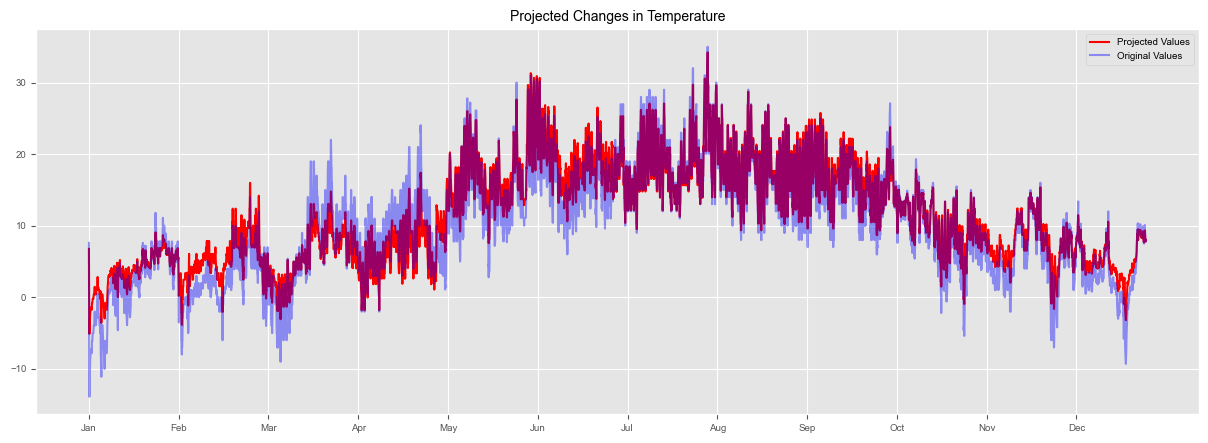

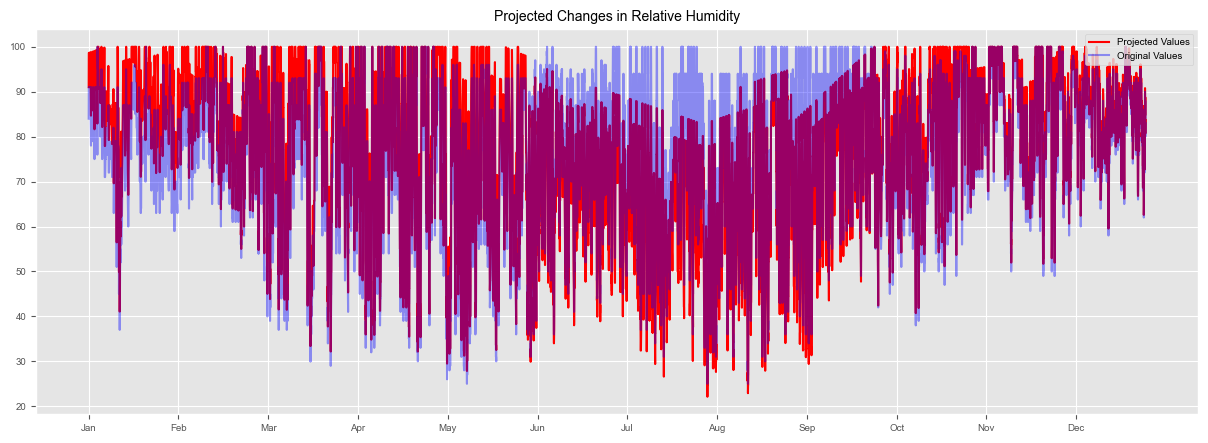

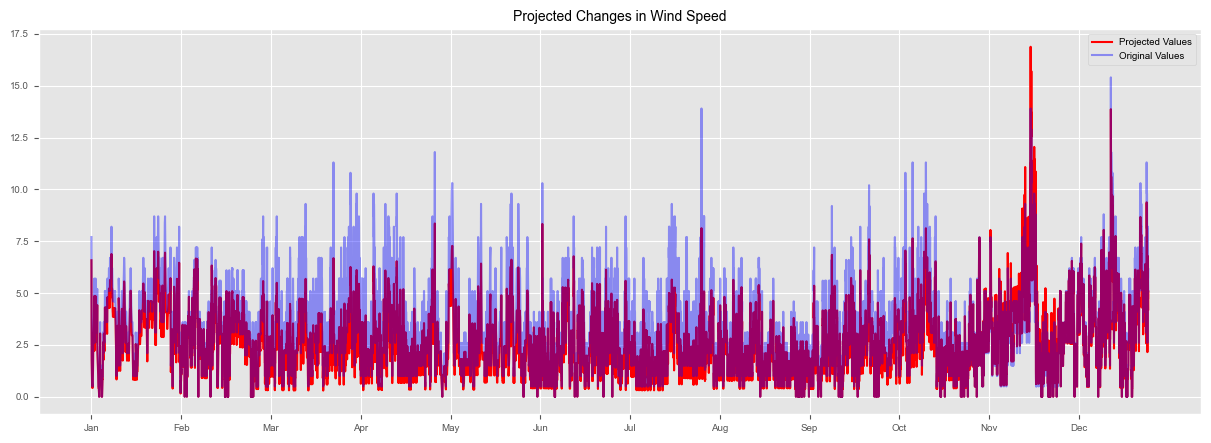

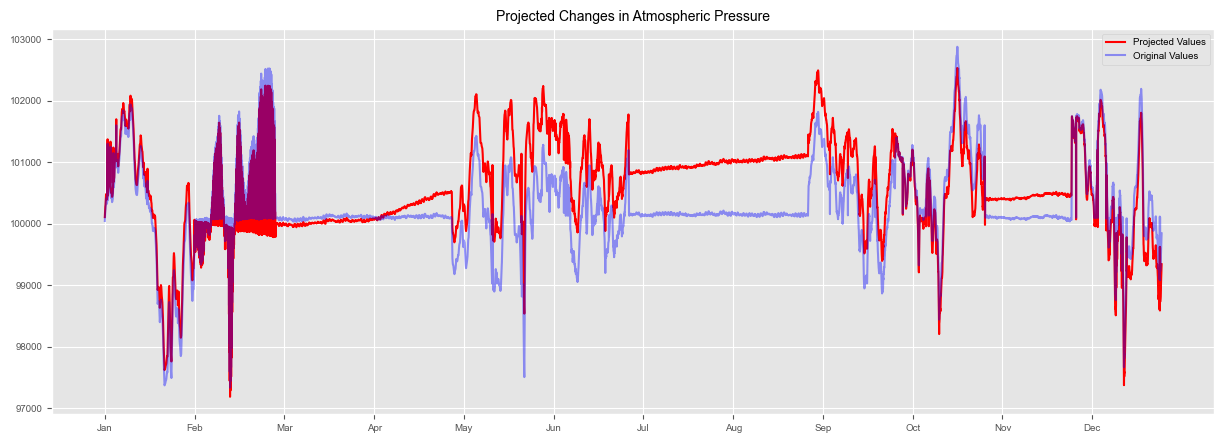

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:181: UserWarning: Forecast for atmospheric pressure returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


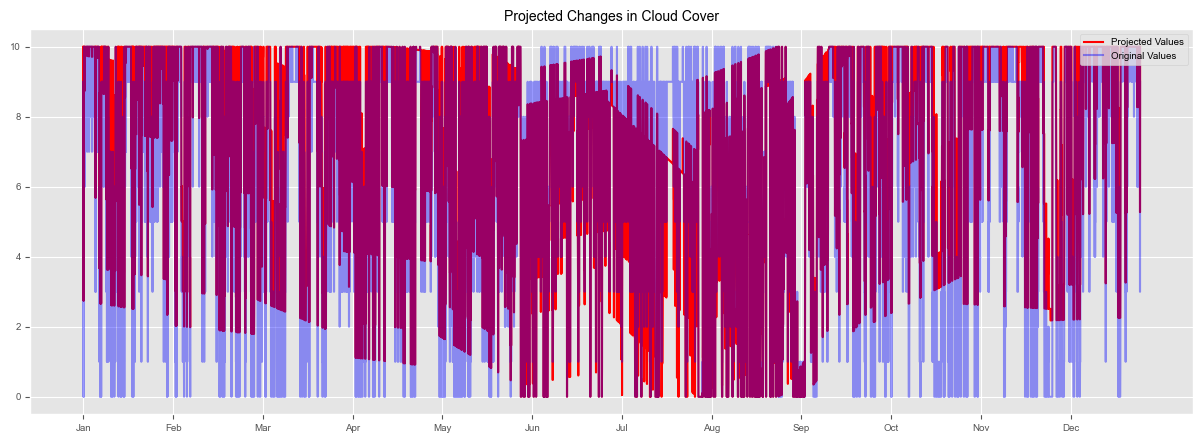

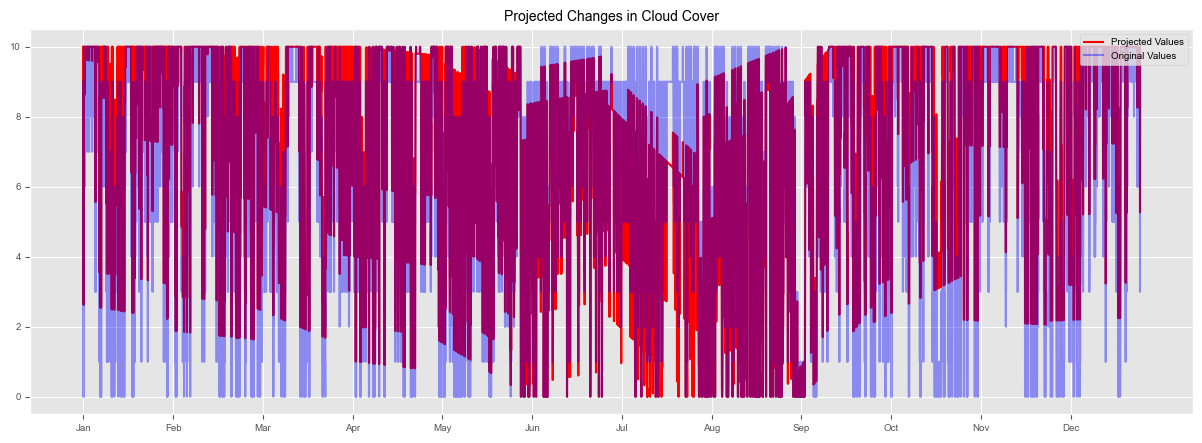

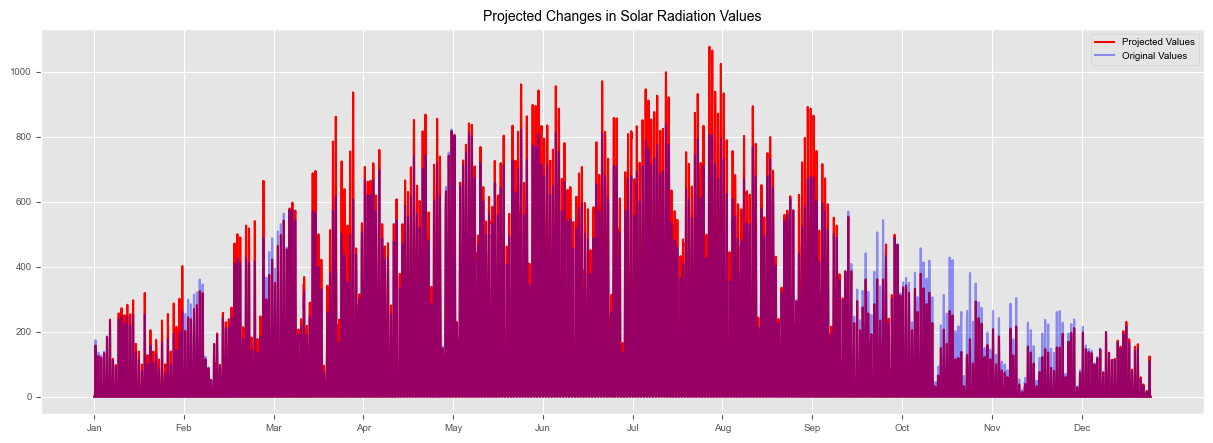

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


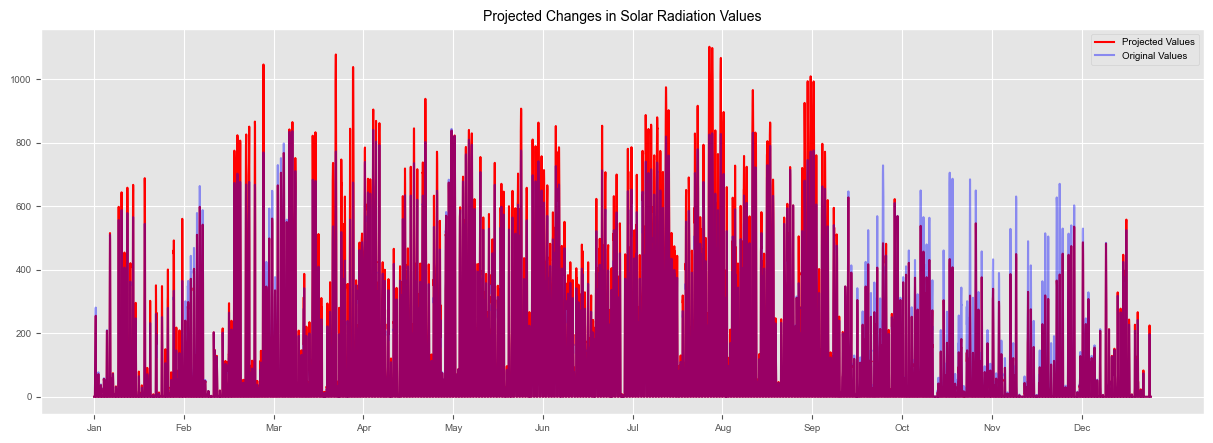

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


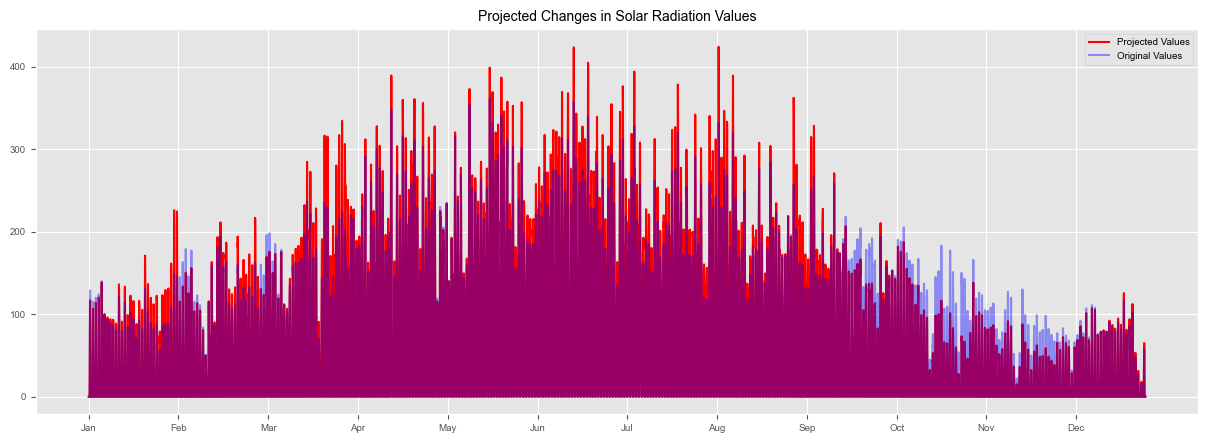

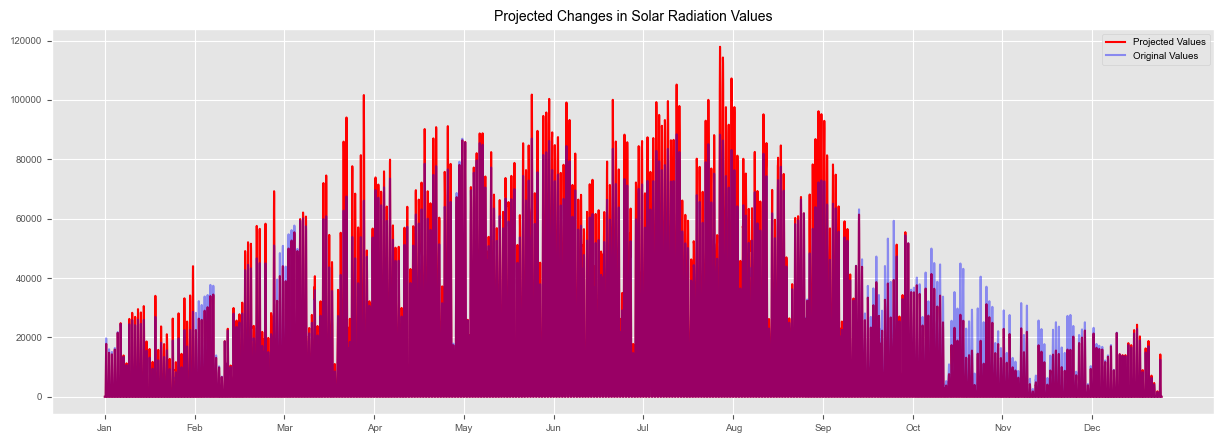

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


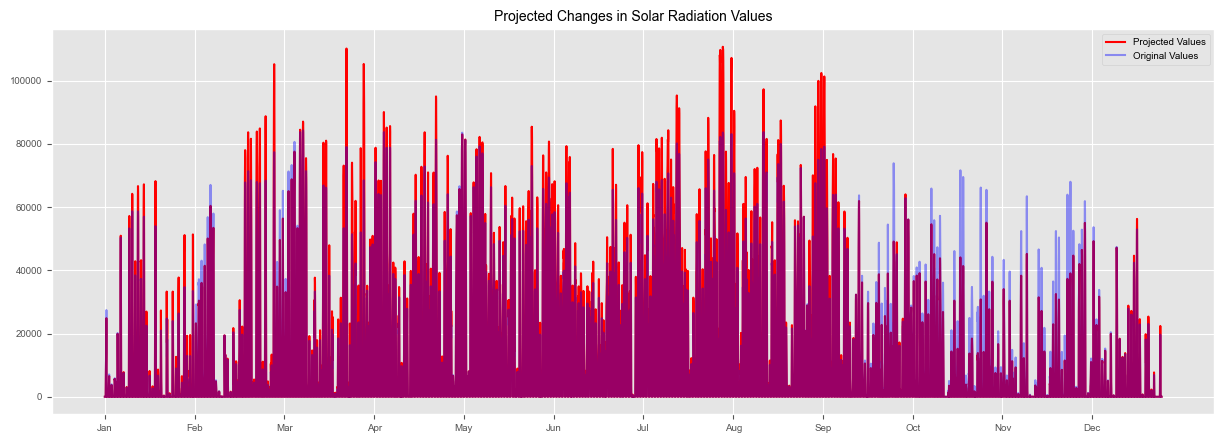

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


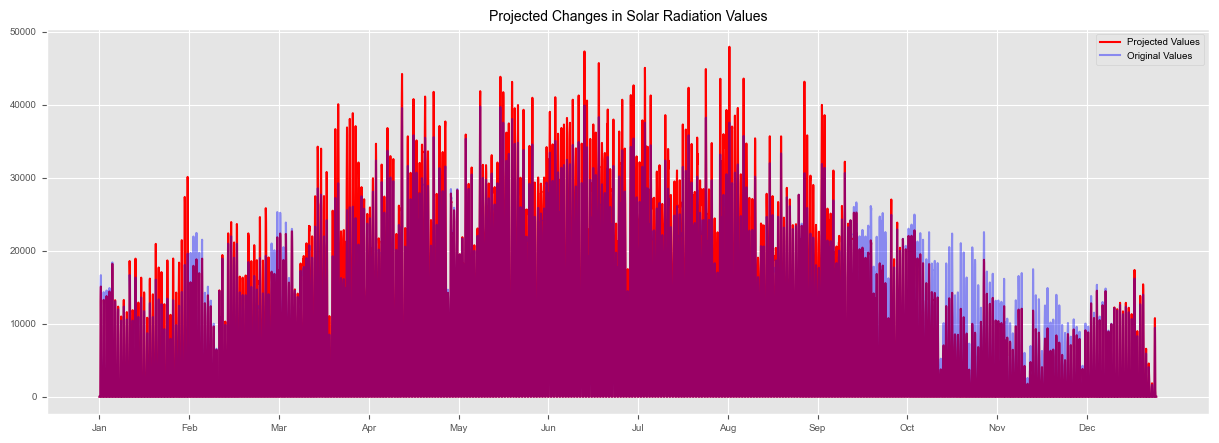

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


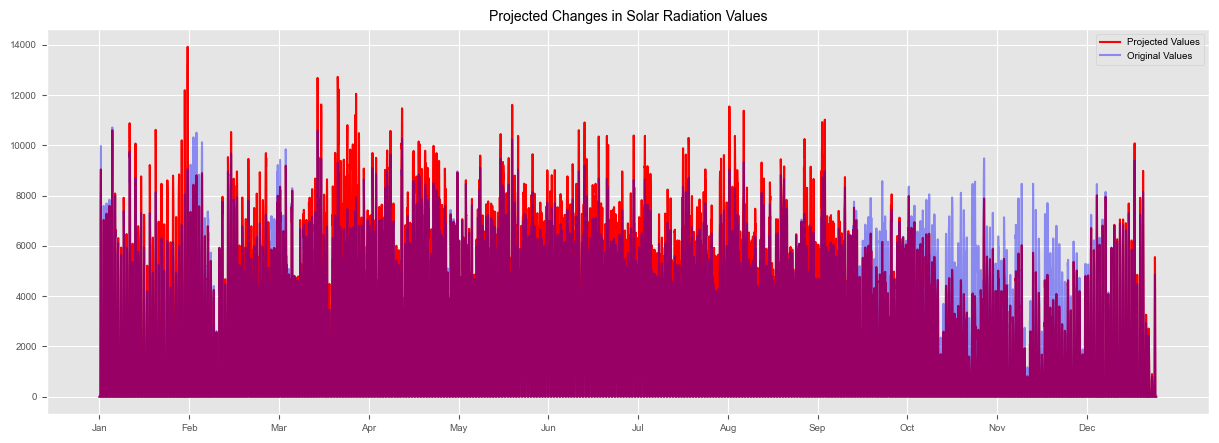

C:\Users\ebendo\AppData\Local\Temp\ipykernel_35584\194122957.py:404: UserWarning: Forecast for solar values returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


'LOCATION,Koln.Bonn.AP,NW,DEU,SRC-TMYx,105130,50.8644,7.1575,1.0,99.5\nDESIGN CONDITIONS,0\nTYPICAL/EXTREME PERIODS,0,\nGROUND TEMPERATURES,3,0.5,,,,6.41,5.71,3.46,3.92,12.13,16.78,16.44,18.37,18.48,14.41,12.61,7.99,2.0,,,,11.57,10.33,4.43,4.01,10.38,14.04,13.99,16.27,17.41,14.76,14.71,11.27,4.0,,,,15.84,15.14,5.87,4.65,9.75,12.25,11.98,14.12,15.73,14.19,15.51,13.41\nHOLIDAYS/DAYLIGHT SAVINGS,No,0,0,0\nCOMMENTS 1,"NCEI ISD/ERA5 - #years=[65] Period of Record=1934-2021; Jan=1971; Feb=1976; Mar=2010; Apr=2006; May=1967; Jun=1982; Jul=2005; Aug=2013; Sep=1981; Oct=1983; Nov=2016; Dec=1986". Forecast using transformation factors from the IPCC HadCM3 sp85 emissions scenario for 2050 according to the methodology from Jentsch M.F., James P.A.B., Bourikas L. and Bahaj A.S. (2013) Transforming existing weather data for worldwide locations to enable energy and building performance simulation under future climates, Renewable Energy, Volume 55, pp 514-524.\nCOMMENTS 2,"Downloaded from Climate.Oneb

In [65]:
#Set original EPW file path
epw = EPW("./TestEPW/Koln.epw")
#Choose forecasting options
future_epw = forecast_epw(epw, "sp85", '2050')
#Save epw with a new title
future_epw.save("./FutureTest.epw")